In [1]:
import json
import os
import numpy as np
import scipy.ndimage
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random

# Define base directory for your data
base_dir = 'k:/HSI/'

# Load the JSON files
def load_data(file_path):
    with open(file_path) as f:
        return json.load(f)

data_train = load_data('k:/HSI/train_only_labeled_v2.json')

# Map ripeness states to numerical labels
ripeness_map = {
    "unripe": 0,
    "perfect": 1,
    "overripe": 2
}

# Function to read the binary data
def read_bin_file(bin_file_path, hdr_file_path):
    try:
        with open(hdr_file_path, 'r') as f:
            for line in f:
                if "samples" in line:
                    width = int(line.split('=')[-1].strip())
                elif "lines" in line:
                    height = int(line.split('=')[-1].strip())
                elif "bands" in line:
                    bands = int(line.split('=')[-1].strip())

        bin_path = os.path.join(base_dir, bin_file_path)
        with open(bin_path, 'rb') as f:
            data = np.fromfile(f, dtype=np.float32)
        data = data.reshape((height, width, bands))
        
        return data
    
    except FileNotFoundError as e:
        print(f"File not found: {e.filename}")
        return None

# Function to resize hyperspectral data to a consistent shape
def resize_hyperspectral_data(data, target_shape=(64, 64, 224)):
    current_shape = data.shape
    if current_shape != target_shape:
        zoom_factors = [target_shape[i] / current_shape[i] for i in range(3)]
        resized_data = scipy.ndimage.zoom(data, zoom_factors, order=1)
        return resized_data
    return data

# Function to extract features and labels
def extract_features_and_labels(data, annotations_dict, X_list, y_ripeness_list):
    for record in data['records']:
        if record['fruit'].lower() == "kaki":
            bin_file = record['files']['data_file']
            hdr_file = record['files']['header_file']
            record_id = record['id']
            
            # Load and resize hyperspectral data
            hyperspectral_data = read_bin_file(bin_file, hdr_file)
            if hyperspectral_data is None:
                continue
            
            hyperspectral_data = resize_hyperspectral_data(hyperspectral_data)
            X_list.append(hyperspectral_data)

            # Get ripeness annotation
            if record_id in annotations_dict:
                ripeness_state = annotations_dict[record_id]['ripeness_state']
                y_ripeness_list.append(ripeness_map[ripeness_state])
            else:
                print(f"Warning: No annotation found for record_id {record_id}")

# Prepare training data
annotations_dict_train = {annot['record_id']: annot for annot in data_train['annotations']}
X, y_ripeness = [], []
extract_features_and_labels(data_train, annotations_dict_train, X, y_ripeness)

# Convert to numpy arrays
X = np.array(X)
y_ripeness = np.array(y_ripeness)

# One-hot encode the ripeness labels
y_ripeness = to_categorical(y_ripeness, num_classes=3)

# Function to augment a single hyperspectral image by applying random transformations
def augment_image(data):
    if random.choice([True, False]):
        data = np.flip(data, axis=0)  # Flip vertically
    if random.choice([True, False]):
        data = np.flip(data, axis=1)  # Flip horizontally
    if random.choice([True, False]):
        data = scipy.ndimage.rotate(data, angle=random.randint(-20, 20), axes=(0, 1), reshape=False)
    if random.choice([True, False]):
        shift = random.uniform(-0.1, 0.1)
        data = scipy.ndimage.shift(data, shift=[shift, shift, 0], mode='nearest')
    
    return data

# Function to balance classes using augmentation
def balance_classes(X, y, target_count=84):
    X_balanced, y_balanced = [], []
    for class_label in range(3):  # For each class label
        class_indices = np.where(np.argmax(y, axis=1) == class_label)[0]
        current_count = len(class_indices)
        print("i am in")
        # Add original samples for the class
        for idx in class_indices:
            X_balanced.append(X[idx])
            y_balanced.append(y[idx])
        
        # Generate augmented samples if the current count is less than the target count
        if current_count < target_count:
            augment_needed = target_count - current_count
            for _ in range(augment_needed):
                original = X[random.choice(class_indices)]
                augmented = augment_image(original)
                X_balanced.append(augmented)
                y_balanced.append(to_categorical(class_label, num_classes=3))
    
    return np.array(X_balanced), np.array(y_balanced)

# Balance the classes
target_count = max(np.count_nonzero(y_ripeness == 1), 84)  # Setting target as the highest count among classes
X_balanced, y_balanced = balance_classes(X, y_ripeness, target_count=target_count)
print(y_balanced)
# Train-test split on the balanced dataset
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Print the shapes to verify
print("Shapes after balancing:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)


i am in
i am in
i am in
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Shapes after balancing:
X_train: (268, 64, 64, 224)
y_train: (268, 3)
X_val: (68, 64, 64, 224)
y_val: (68, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 64, 64, 224)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 64)        │         702,528 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 32, 64)        │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 32, 32, 64)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 16, 16, 64)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 16, 16, 64)        │          36,928 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 16, 16, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 16, 16, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 16, 16, 64)        │          36,928 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 16, 16, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 16, 16, 64)        │               0 │ batch_normalization_2[0][… │
│                               │                           │                 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 16, 16, 64)        │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 16, 16, 64)        │          36,928 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 16, 16, 64)        │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 16, 16, 64)        │               

 Total params: 11,885,507 (45.34 MB)

 Trainable params: 11,875,907 (45.30 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 451ms/step - accuracy: 0.4770 - loss: 1.9376 - val_accuracy: 0.3235 - val_loss: 640.3082
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 439ms/step - accuracy: 0.6077 - loss: 0.9159 - val_accuracy: 0.3235 - val_loss: 70.4322
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - accuracy: 0.6738 - loss: 0.7826 - val_accuracy: 0.3235 - val_loss: 23.9704
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - accuracy: 0.5718 - loss: 1.0924 - val_accuracy: 0.3235 - val_loss: 8.6401
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.7896 - loss: 0.5672 - val_accuracy: 0.3824 - val_loss: 1.3959
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step - accuracy: 0.7742 - loss: 0.5394 - val_accuracy: 0.1765 - val_loss: 1.9416
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step - accuracy: 0.7750 - loss: 0.5166 - val_accuracy: 0.5147 - val_loss: 1.4366
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - accuracy: 0.7155 - loss: 0.6579 - val

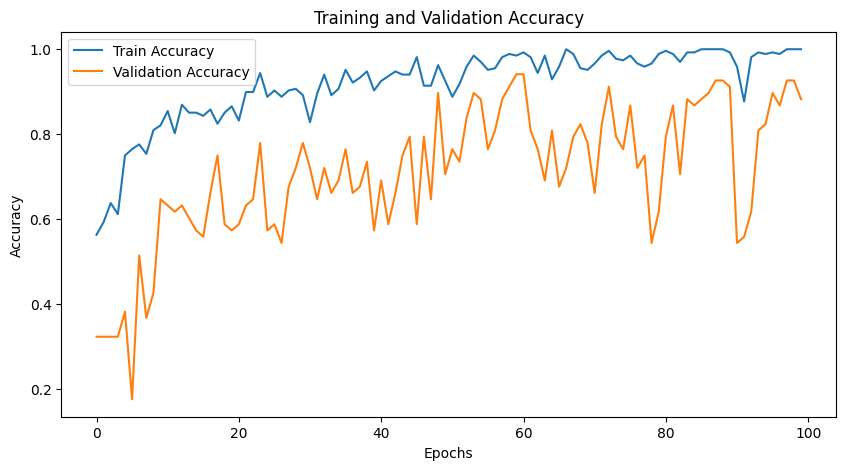

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
Classification Report:
              precision    recall  f1-score   support

      unripe       0.93      1.00      0.96        26
     perfect       0.77      0.85      0.81        20
    overripe       0.94      0.77      0.85        22

    accuracy                           0.88        68
   macro avg       0.88      0.87      0.87        68
weighted avg       0.89      0.88      0.88        68



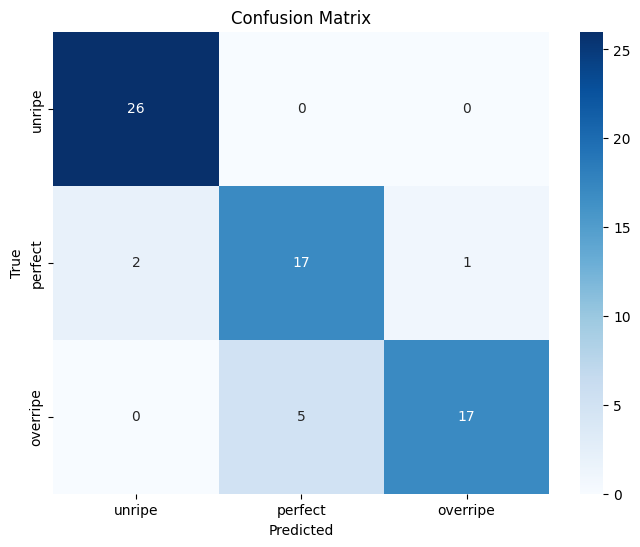

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define a Residual Block for ResNet-18
def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    shortcut = x
    if downsample:
        x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = BatchNormalization()(x)

        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    else:
        x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Define ResNet-18 model architecture
def build_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Define each stage with residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, downsample=True)
    x = residual_block(x, 512)

    # Global average pooling and output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Model parameters
input_shape = (64, 64, 224)  # Adjust based on your hyperspectral data shape
num_classes = 3

# Build and compile the ResNet-18 model
model = build_resnet18(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Model Evaluation
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=['unripe', 'perfect', 'overripe']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['unripe', 'perfect', 'overripe'], yticklabels=['unripe', 'perfect', 'overripe'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
